In [58]:
!pip install segmentation_models_pytorch

In [59]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import random

import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_pil_image

from torchmetrics.segmentation import DiceScore, MeanIoU

from glob import glob
import shutil
import os

# 1. Предобработка данных

In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [61]:
def split_data(path):
    for index, file in enumerate(os.listdir(path)):
        current = path + '/' + file

        if index % 10 == 8:
            os.rename(current, path + '/' + 'val_' + file)

        elif index % 10 == 9:
            os.rename(current, path + '/' + 'test_' + file)

        else:
            os.rename(current, path + '/' + 'train_' + file)

In [62]:
current_dir = '/kaggle/input'
print(current_dir)

print("IMG exists:", os.path.exists(current_dir + '/darwin/Darwin/img'))
print("MASK exists:", os.path.exists(current_dir + '/darwin/Darwin/mask'))

#split_data(current_dir + '/Darwin/img')
#split_data(current_dir + '/Darwin/mask')

/kaggle/input
IMG exists: True
MASK exists: True


# 2. Вспомогательные функции

In [63]:
def plot_loss(train_loss, valid_loss):
    plt.figure(figsize=(12, 8))
    plt.semilogy(range(len(train_loss)), train_loss, label = "Train")
    plt.semilogy(range(len(valid_loss)), valid_loss, label = "Val")
    plt.title("Ошибка во время обучения")
    plt.ylabel("Ошибка")
    plt.xlabel("Эпоха")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
sigmoid = nn.Sigmoid()

def debug_image_output(X, y, y_):
    real_output = y.squeeze().cpu()
    nn_output = sigmoid(y_.cpu())
    nn_output = (nn_output[0, :, :] >= 0.5).long()
    img = X.cpu()

    plt.imshow(to_pil_image(img))
    plt.title("Изображение")
    plt.show()
    plt.imshow(real_output, cmap = 'jet')
    plt.title("Реальная сегментация")
    plt.show()
    plt.imshow(nn_output, cmap = 'jet')
    plt.title("Вывод нейросети")
    plt.show()

# 3. Создадим кастомный класс датасета

In [65]:
class DarwinDataset(Dataset):
    def __init__(self, img_dir, mask_dir, data_type, transform = None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.data_type = data_type
        self.transform = transform

        self.file_ids = [file for file in os.listdir(self.img_dir) if file.split('_')[0] == self.data_type]

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, index):
        file_id = self.file_ids[index]
        img_path = os.path.join(self.img_dir, file_id)
        mask_path = os.path.join(self.mask_dir, file_id)

        img = Image.open(img_path) #.convert("RGB")
        mask = Image.open(mask_path) #.convert("L")

        if self.transform:
            transformed = self.transform(image = np.array(img), mask = np.array(mask))
            img = transformed['image']
            mask = transformed['mask'] != 0

        return img, mask.int()

In [66]:
train_transform = A.Compose([
    A.HorizontalFlip(p = 0.5),
    #A.RandomBrightnessContrast(p = 0.2),
    #A.Normalize(mean = (0.5,), std = (0.5,)),
    A.ShiftScaleRotate(shift_limit = 0.1, scale_limit = 0.1, rotate_limit = 45, p = 0.5),
    ToTensorV2(),
])

val_test_transform = A.Compose([
    ToTensorV2()
])

X_image_dir = current_dir + '/darwin/Darwin/img'
y_image_dir = current_dir + '/darwin/Darwin/mask'

TrainDataset = DarwinDataset(X_image_dir, y_image_dir, 'train', train_transform)
ValDataset = DarwinDataset(X_image_dir, y_image_dir, 'val', val_test_transform)
TestDataset = DarwinDataset(X_image_dir, y_image_dir, 'test', val_test_transform)

TrainLoader = DataLoader(TrainDataset, 16, True)
ValLoader = DataLoader(ValDataset, 8, False)
TestLoader = DataLoader(TestDataset, 8, False)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


tensor([  0, 255], dtype=torch.int32)


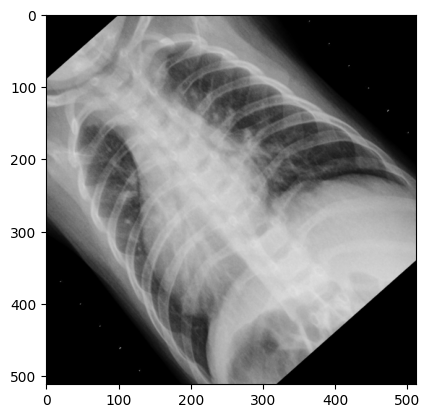

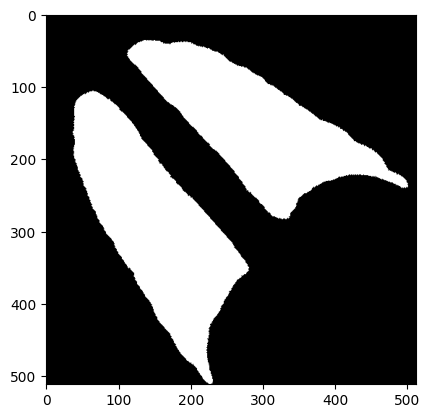

tensor([  0, 255], dtype=torch.int32)


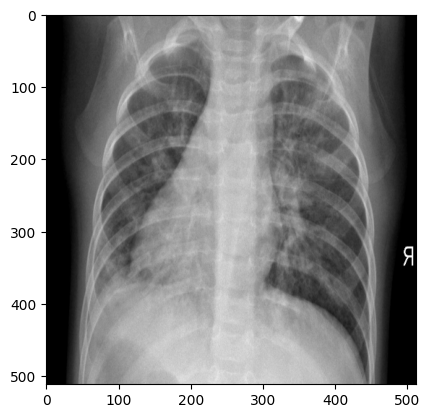

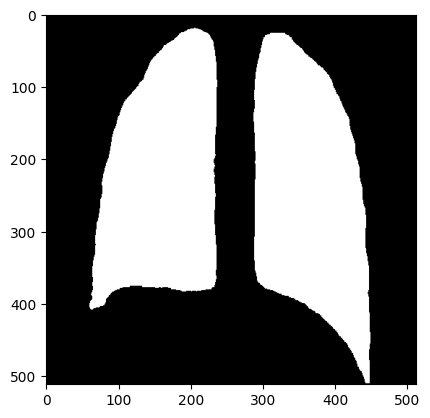

tensor([  0, 255], dtype=torch.int32)


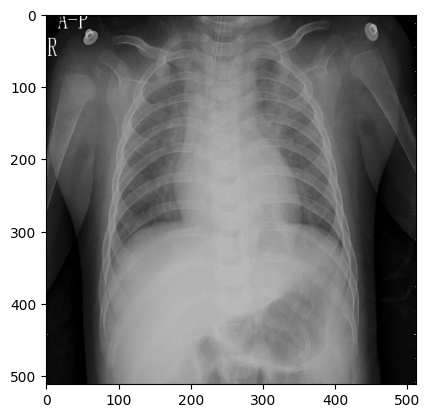

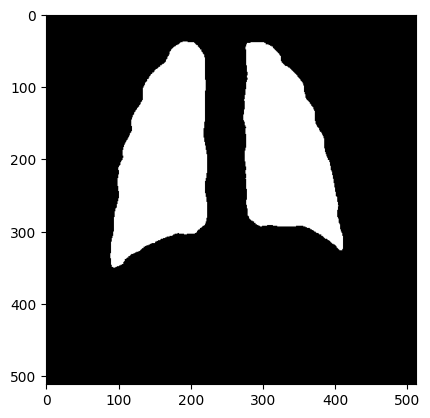

tensor([  0, 255], dtype=torch.int32)


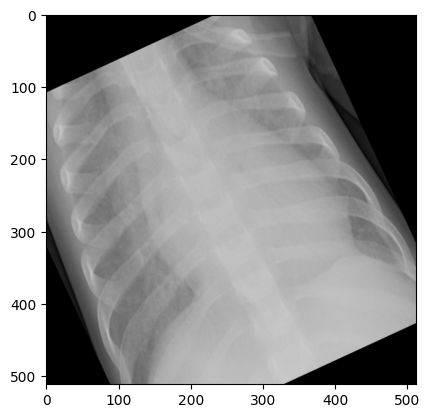

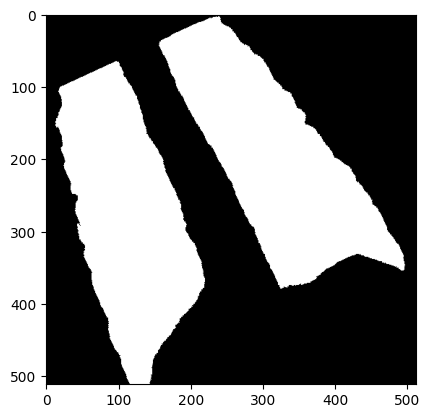

tensor([  0, 255], dtype=torch.int32)


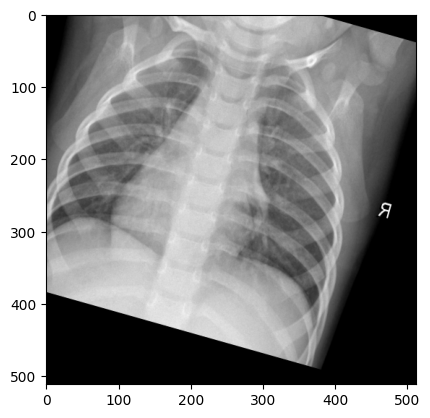

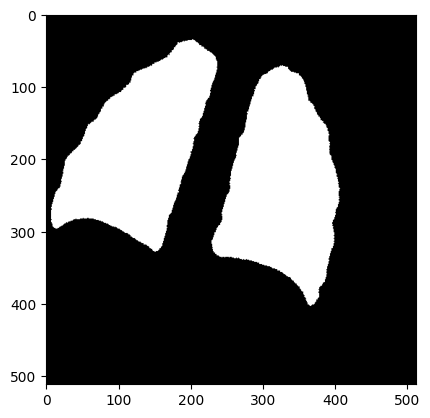

tensor([  0, 255], dtype=torch.int32)


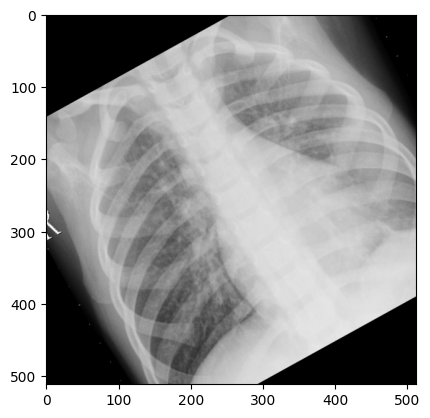

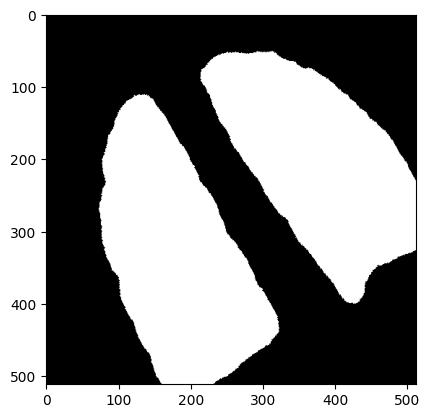

tensor([  0, 255], dtype=torch.int32)


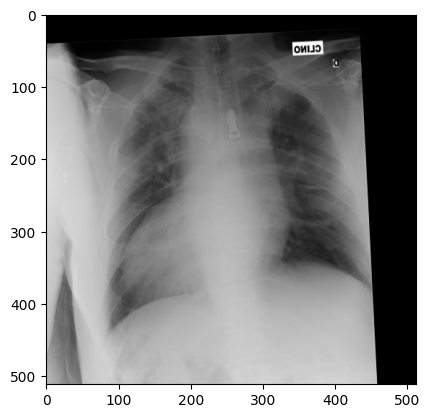

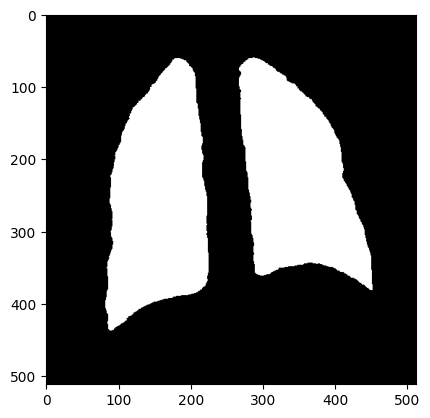

tensor([  0, 255], dtype=torch.int32)


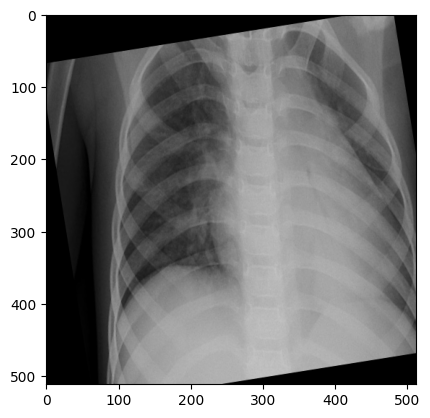

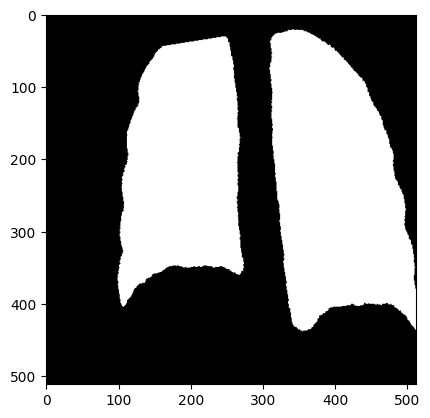

tensor([  0, 255], dtype=torch.int32)


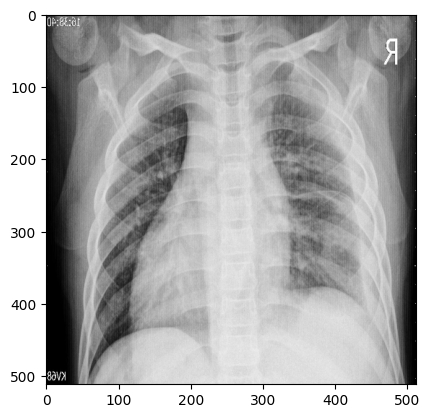

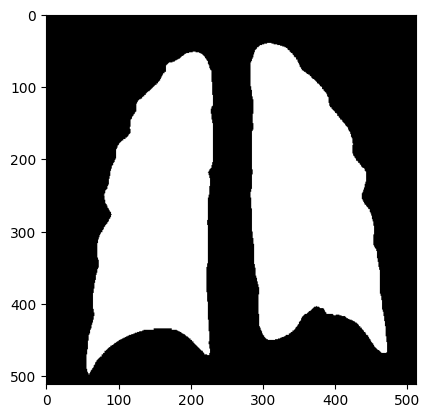

tensor([  0, 255], dtype=torch.int32)


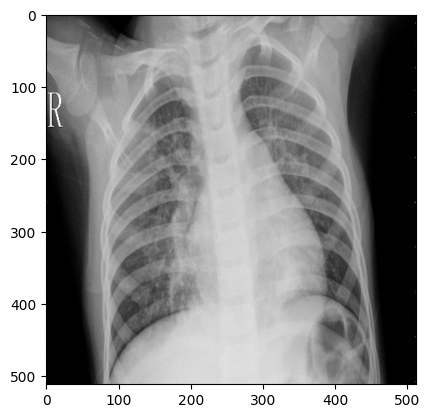

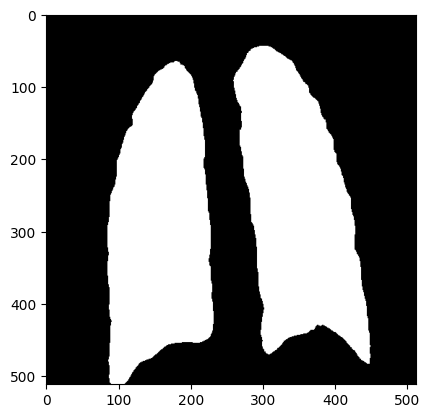

tensor([  0, 255], dtype=torch.int32)


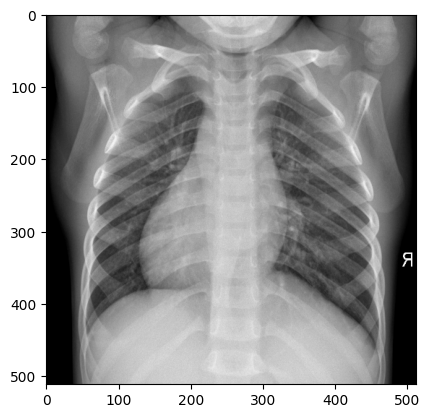

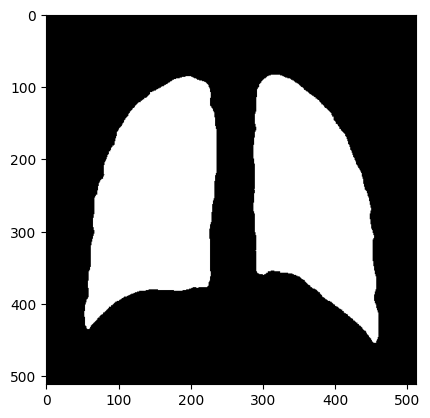

tensor([  0, 255], dtype=torch.int32)


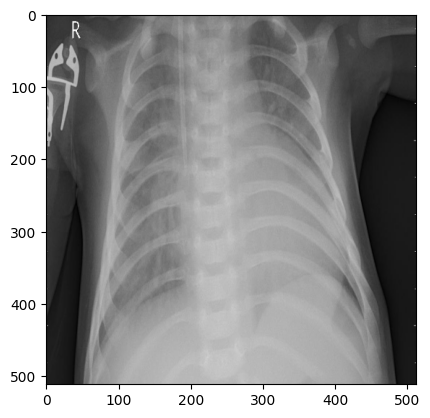

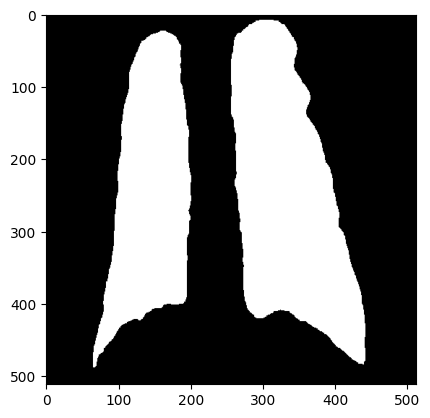

tensor([  0, 255], dtype=torch.int32)


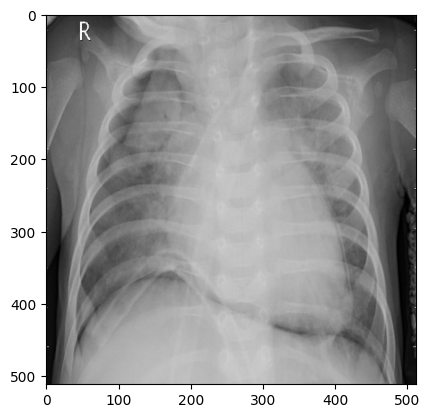

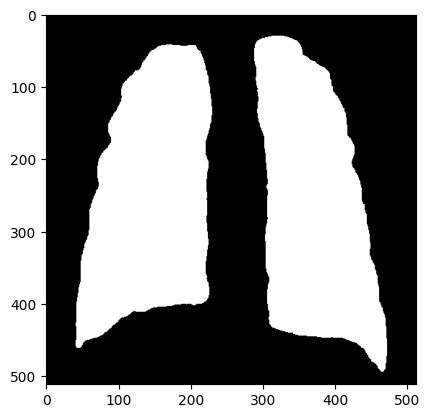

tensor([  0, 255], dtype=torch.int32)


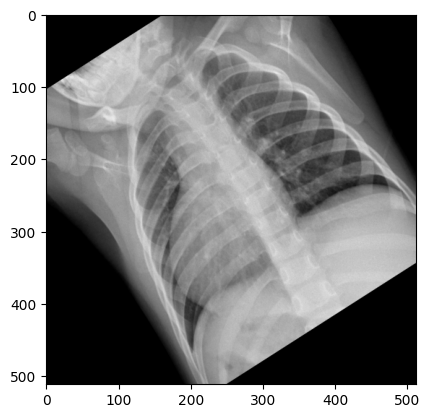

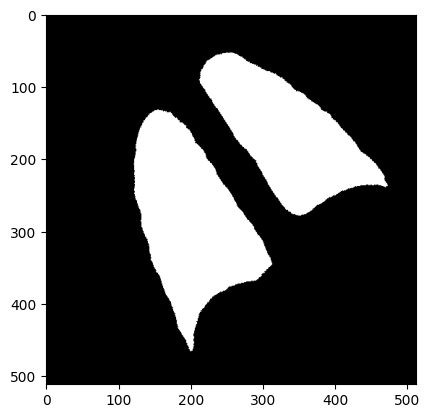

tensor([  0, 255], dtype=torch.int32)


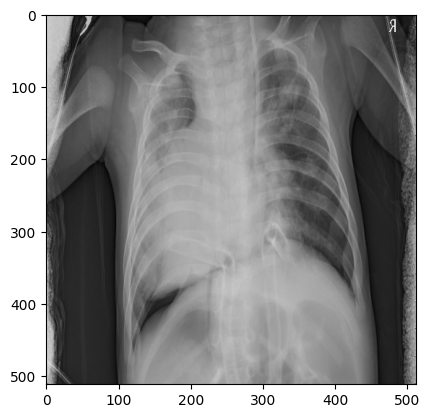

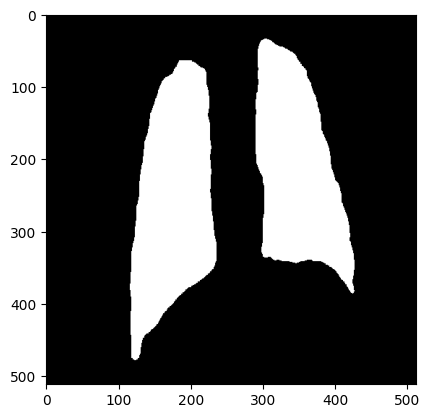

tensor([  0, 255], dtype=torch.int32)


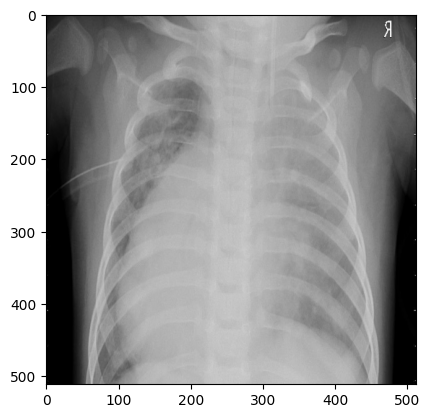

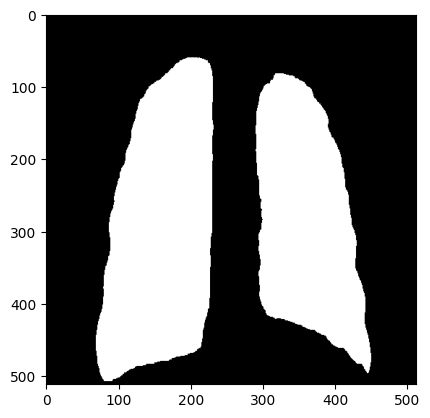

In [67]:
for img, mask in TrainLoader:
    n = img.shape[0]

    for index in range(n):
        img_ = img[index]
        mask_ = mask[index] * 255

        print(torch.unique(mask_))

        plt.imshow(to_pil_image(img_))
        plt.show()
        plt.imshow(to_pil_image(mask_))
        plt.show()

    break

# 4. Обучим модель

In [68]:
Model = smp.Unet(classes = 1)

In [ ]:
def train(model, train_loader, valid_loader, num_epoch, lr, debug_img, debug_mask, device, train_loss = [], valid_loss = [], verbose = 1):
    model.to(device)
    debug_img, debug_mask = debug_img.to(device).float(), debug_mask.to(device).float()

    optimizer = Adam(model.parameters(), lr = lr)
    criterion = nn.BCELoss()
    sigmoid = nn.Sigmoid()

    for epoch in tqdm(range(num_epoch)):
        epoch_train_loss = []
        epoch_valid_loss = []

        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device).float(), targets.to(device).float()

            outputs = model.forward(inputs)
            loss = criterion(sigmoid(outputs.squeeze()), targets)
            epoch_train_loss.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        average_loss = torch.Tensor(epoch_train_loss).mean()
        train_loss.append(average_loss)

        if verbose and epoch % verbose == 0: print(f"Train loss [epoch: {epoch}]: {average_loss}")

        model.eval()
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device).float(), targets.to(device).float()

                outputs = model.forward(inputs)
                loss = criterion(sigmoid(outputs.squeeze()), targets)
                epoch_valid_loss.append(float(loss))

            average_val_loss = torch.Tensor(epoch_valid_loss).mean()
            valid_loss.append(average_val_loss)

            if verbose and epoch % verbose == 0: print(f"Valid loss [epoch: {epoch}]: {average_val_loss}")

            if debug_img is not None and debug_mask is not None:
                y_ = Model.forward(debug_img.unsqueeze(0))
                debug_image_output(debug_img, debug_mask, y_.squeeze(0))

    return train_loss, valid_loss

In [70]:
debug_img, debug_mask = ValDataset[11]

  0%|          | 0/15 [00:00<?, ?it/s]

Train loss [epoch: 0]: 0.32783254981040955
Valid loss [epoch: 0]: 0.19136154651641846


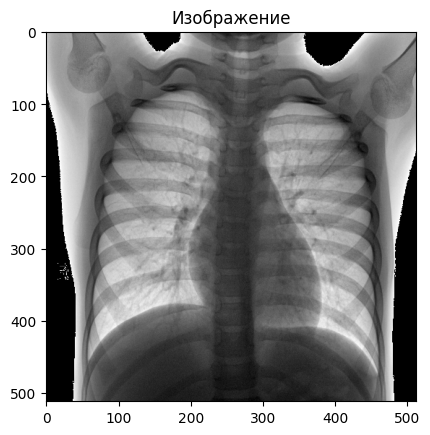

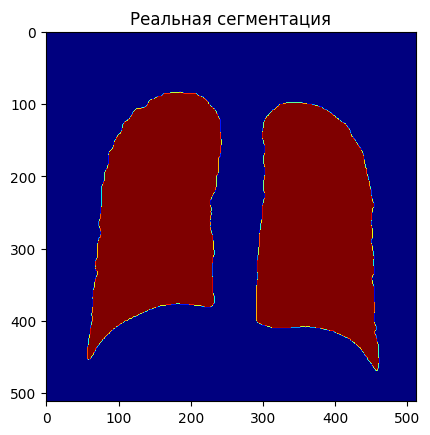

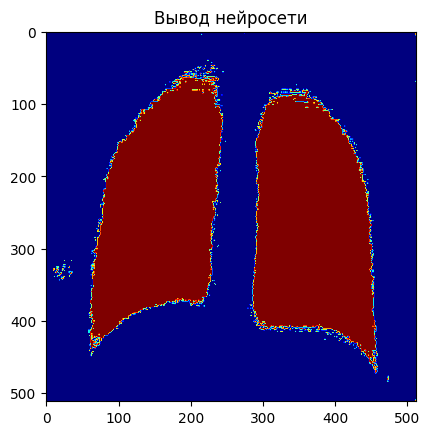

  7%|▋         | 1/15 [04:13<59:12, 253.78s/it]

Train loss [epoch: 1]: 0.15959107875823975
Valid loss [epoch: 1]: 0.13533610105514526


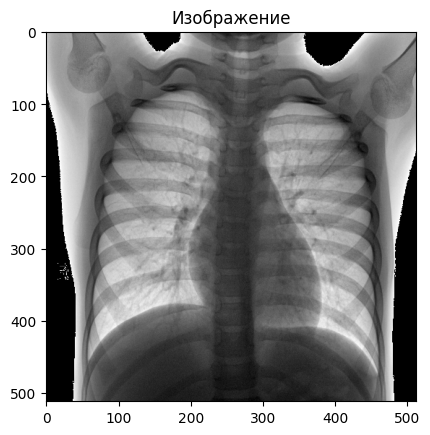

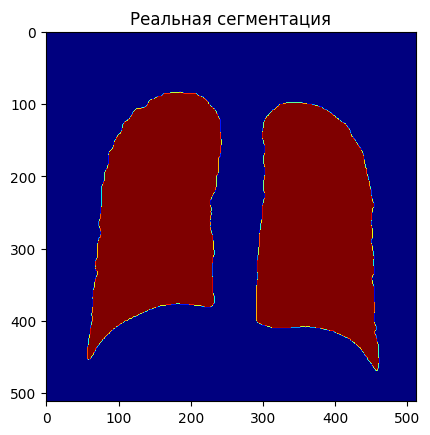

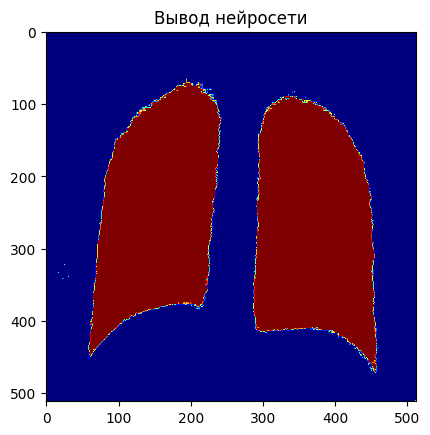

 13%|█▎        | 2/15 [08:26<54:51, 253.16s/it]

Train loss [epoch: 2]: 0.13056904077529907
Valid loss [epoch: 2]: 0.11888965964317322


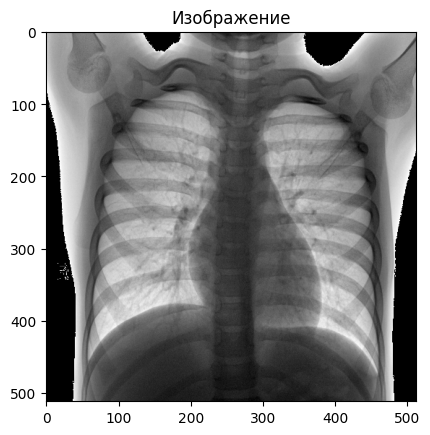

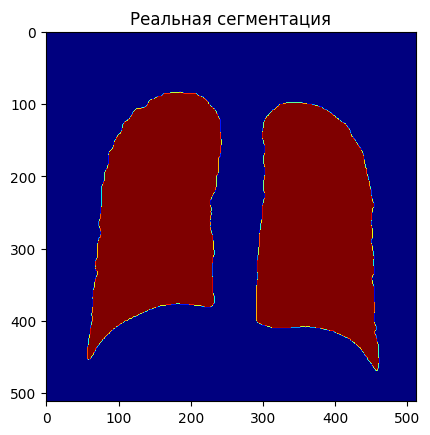

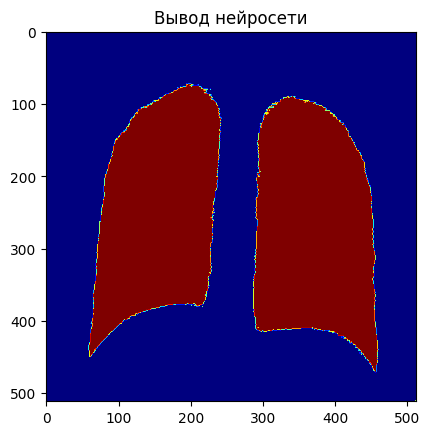

 20%|██        | 3/15 [12:38<50:31, 252.64s/it]

Train loss [epoch: 3]: 0.11601612716913223
Valid loss [epoch: 3]: 0.11272893846035004


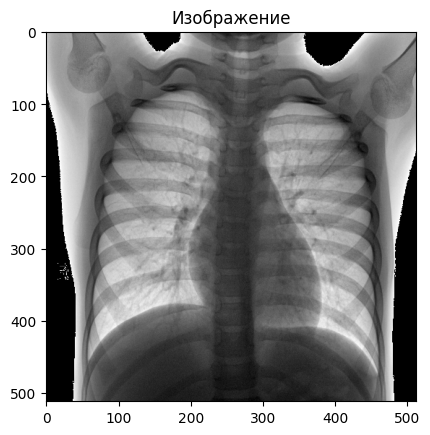

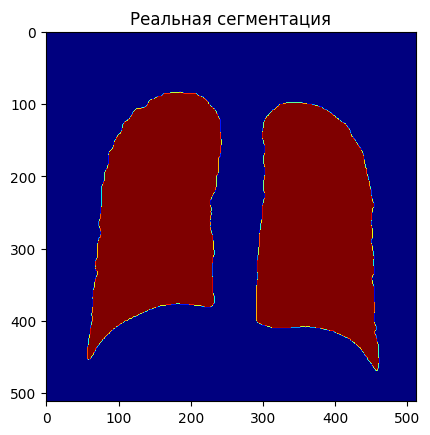

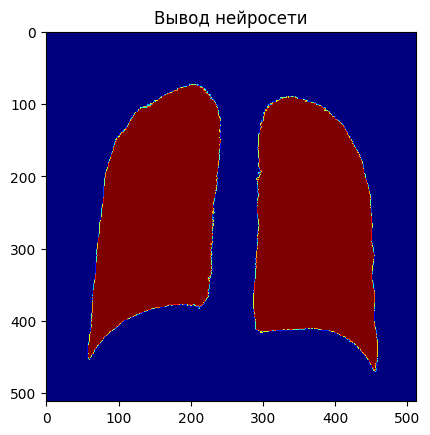

 27%|██▋       | 4/15 [16:50<46:17, 252.49s/it]

Train loss [epoch: 4]: 0.10626176744699478
Valid loss [epoch: 4]: 0.10104522854089737


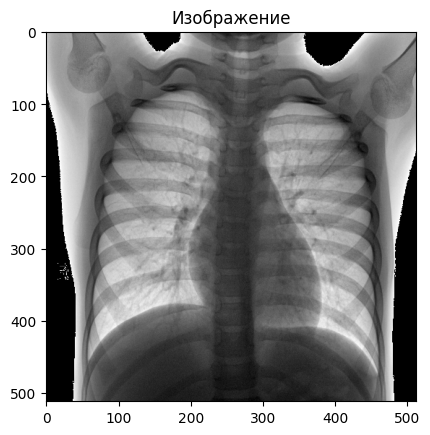

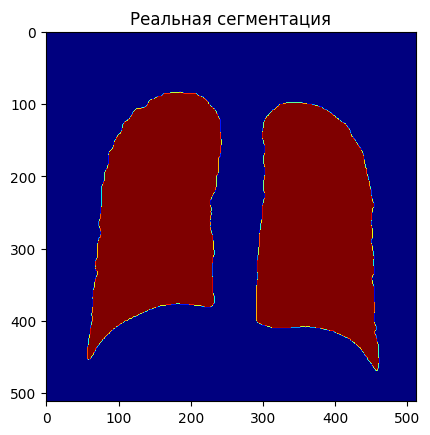

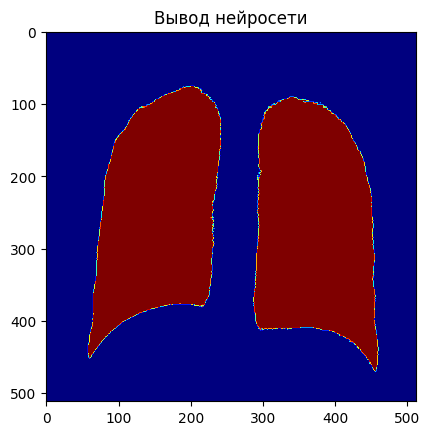

 33%|███▎      | 5/15 [21:02<42:03, 252.38s/it]

Train loss [epoch: 5]: 0.09862936288118362
Valid loss [epoch: 5]: 0.10019564628601074


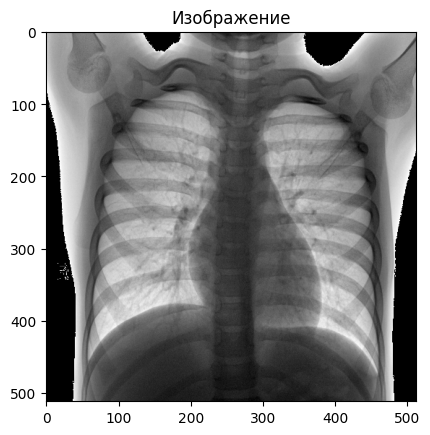

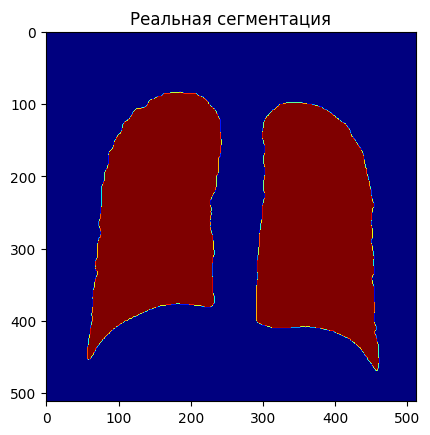

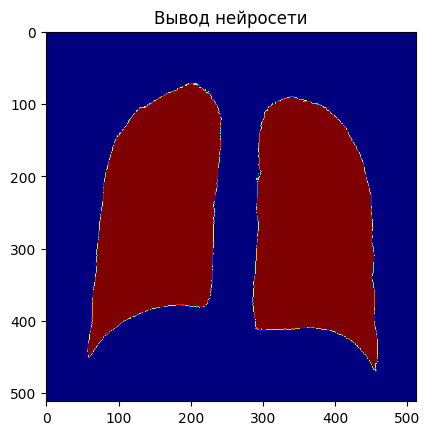

 40%|████      | 6/15 [25:15<37:51, 252.36s/it]

Train loss [epoch: 6]: 0.09289491176605225
Valid loss [epoch: 6]: 0.09004074335098267


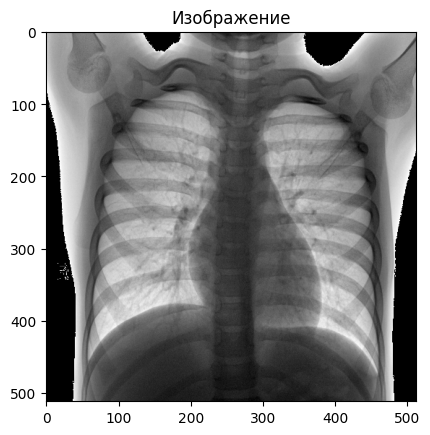

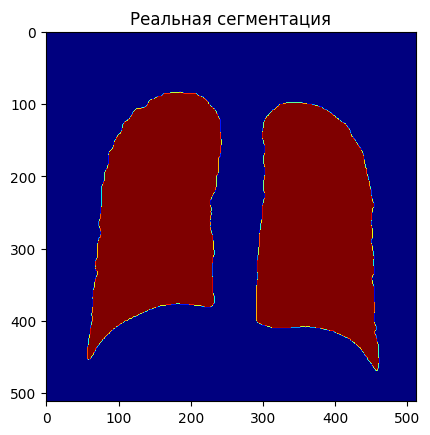

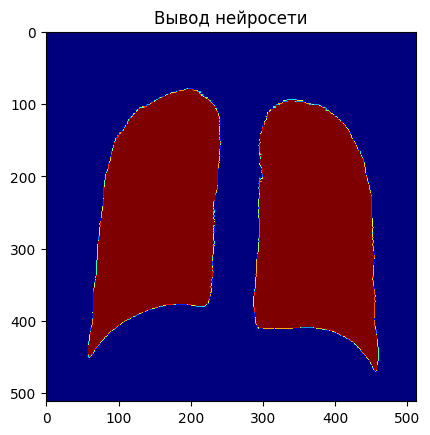

 47%|████▋     | 7/15 [29:27<33:37, 252.17s/it]

Train loss [epoch: 7]: 0.08759865164756775
Valid loss [epoch: 7]: 0.08660665154457092


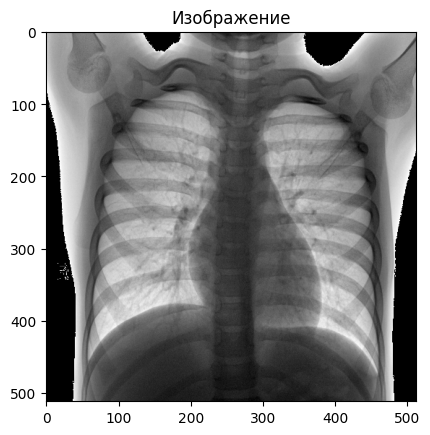

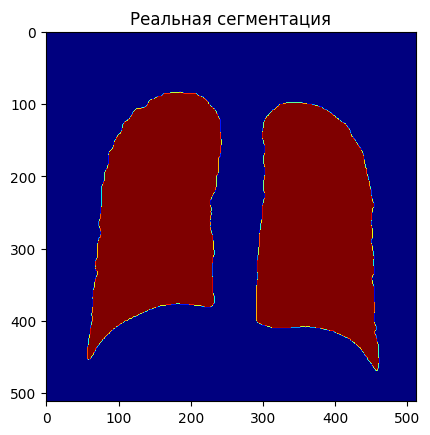

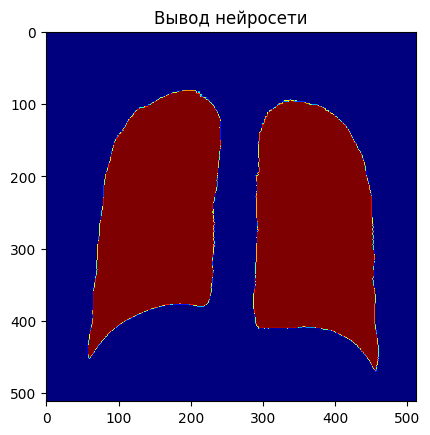

 53%|█████▎    | 8/15 [33:40<29:27, 252.44s/it]

Train loss [epoch: 8]: 0.08420248329639435
Valid loss [epoch: 8]: 0.08464125543832779


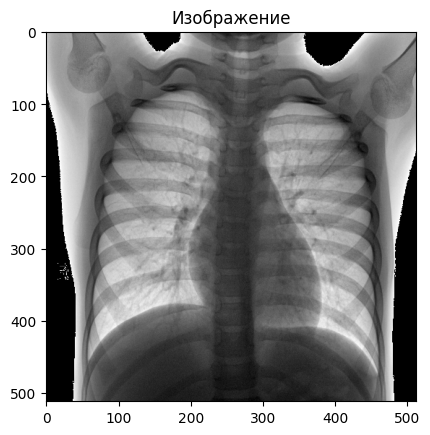

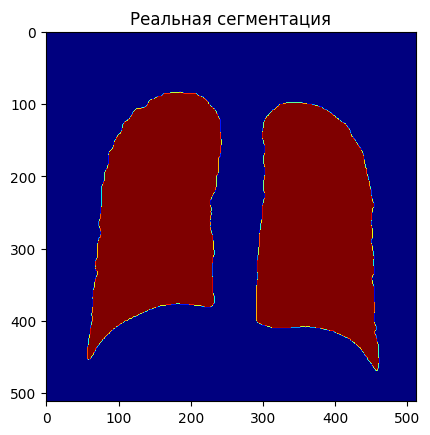

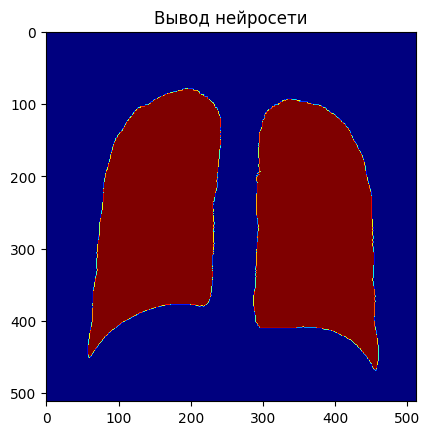

 60%|██████    | 9/15 [37:52<25:14, 252.44s/it]

Train loss [epoch: 9]: 0.08056346327066422
Valid loss [epoch: 9]: 0.08053011447191238


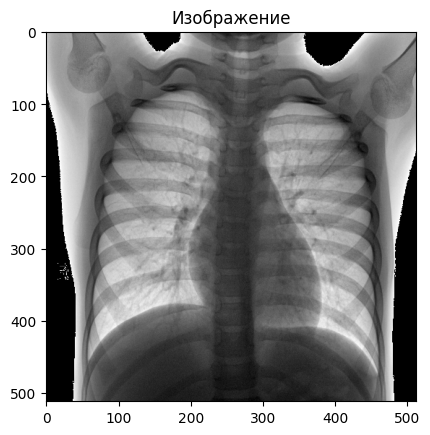

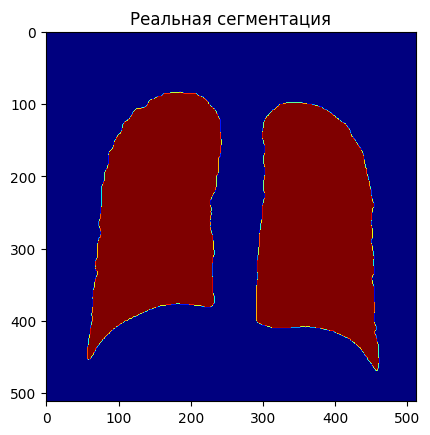

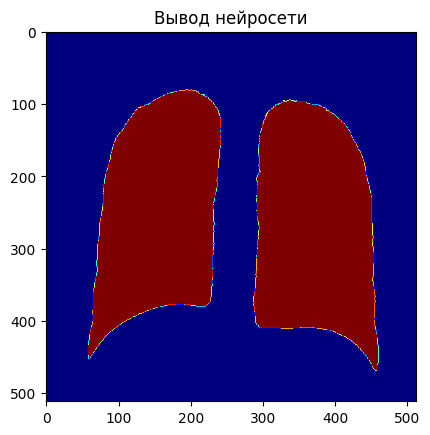

 67%|██████▋   | 10/15 [42:05<21:02, 252.57s/it]

Train loss [epoch: 10]: 0.07717078179121017
Valid loss [epoch: 10]: 0.07883544266223907


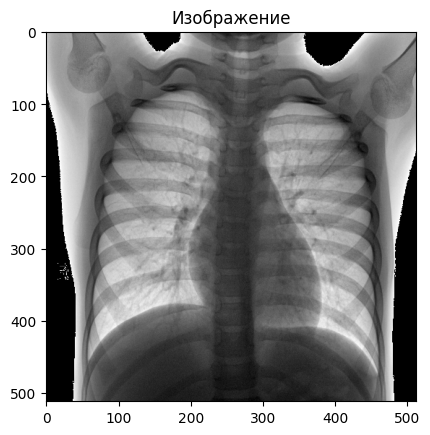

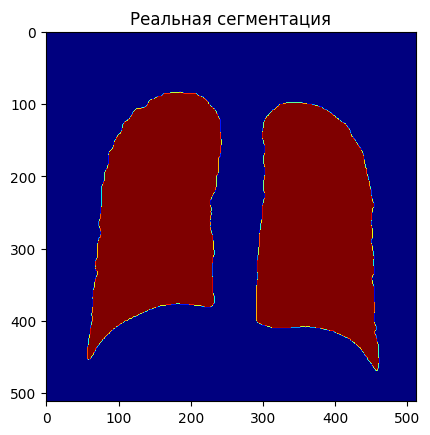

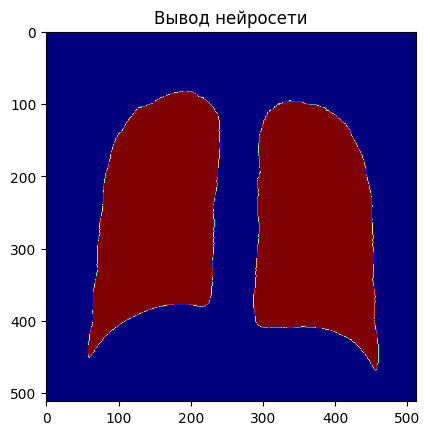

 73%|███████▎  | 11/15 [46:18<16:51, 252.76s/it]

Train loss [epoch: 11]: 0.07485616207122803
Valid loss [epoch: 11]: 0.07707209140062332


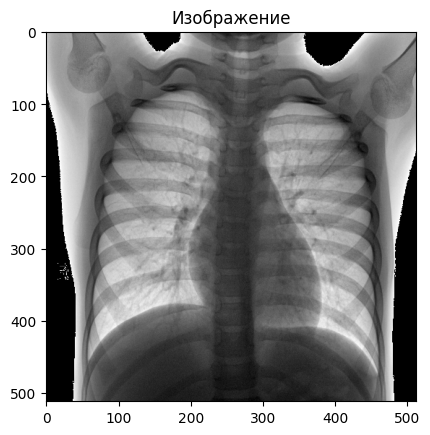

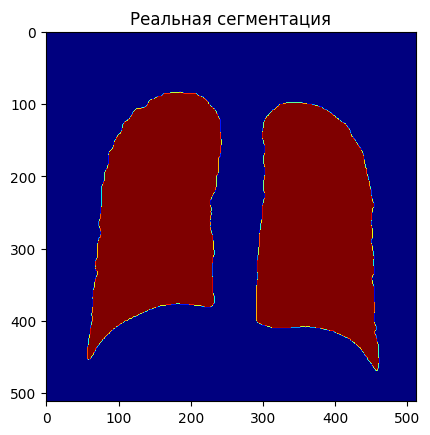

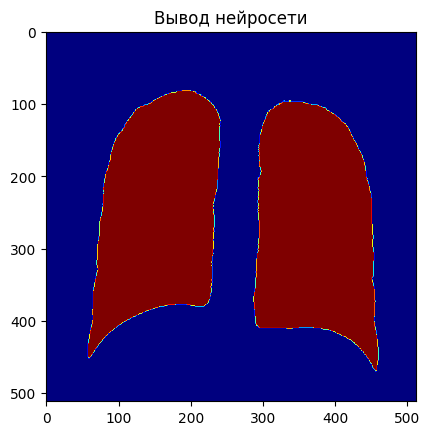

 80%|████████  | 12/15 [50:31<12:38, 252.72s/it]

Train loss [epoch: 12]: 0.07264159619808197
Valid loss [epoch: 12]: 0.07554708421230316


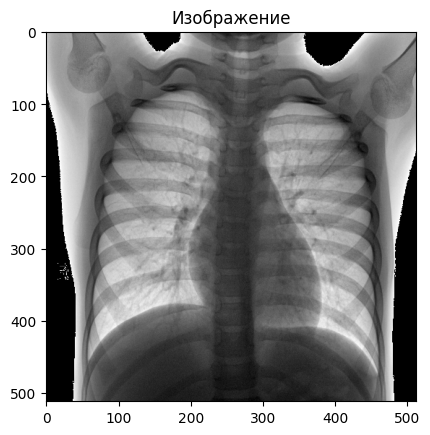

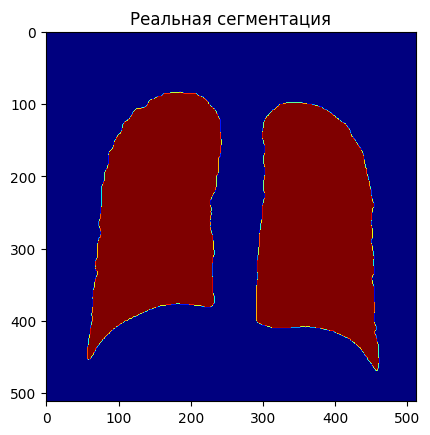

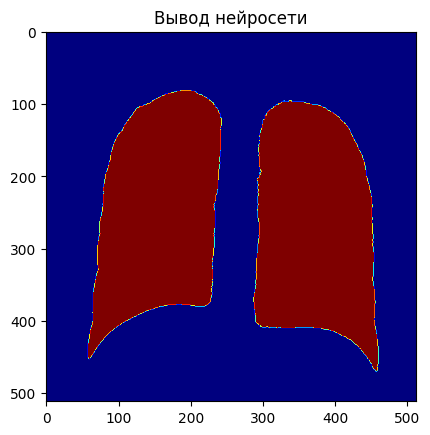

 87%|████████▋ | 13/15 [54:44<08:25, 252.77s/it]

Train loss [epoch: 13]: 0.07036305218935013
Valid loss [epoch: 13]: 0.0742781013250351


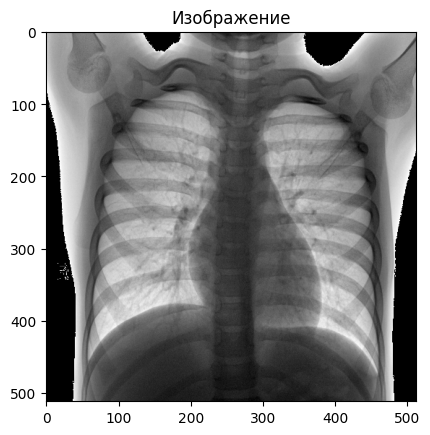

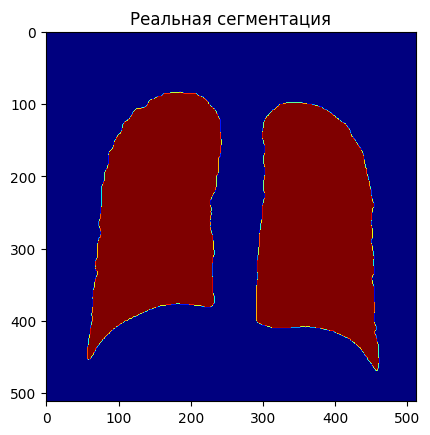

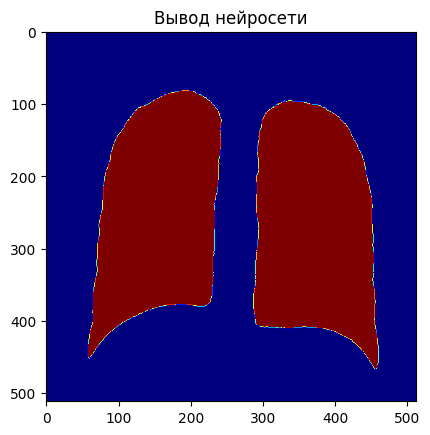

 93%|█████████▎| 14/15 [58:57<04:12, 252.82s/it]

Train loss [epoch: 14]: 0.06859196722507477
Valid loss [epoch: 14]: 0.0728844478726387


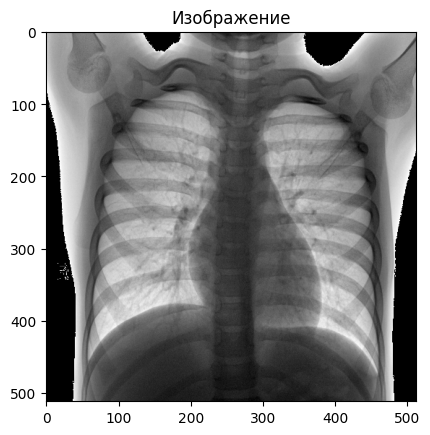

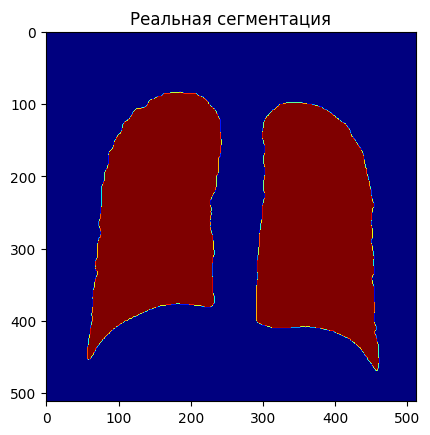

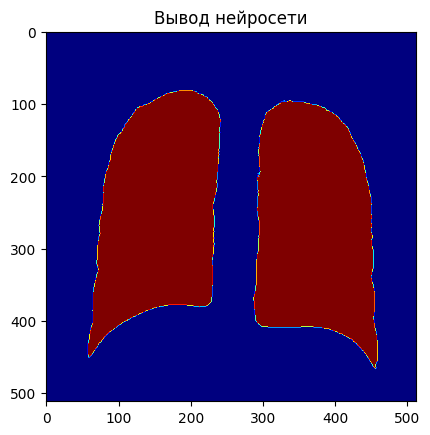

100%|██████████| 15/15 [1:03:09<00:00, 252.64s/it]


In [71]:
train_loss, valid_loss = train(Model, TrainLoader, ValLoader, 15, 10**(-5), debug_img, debug_mask, device)

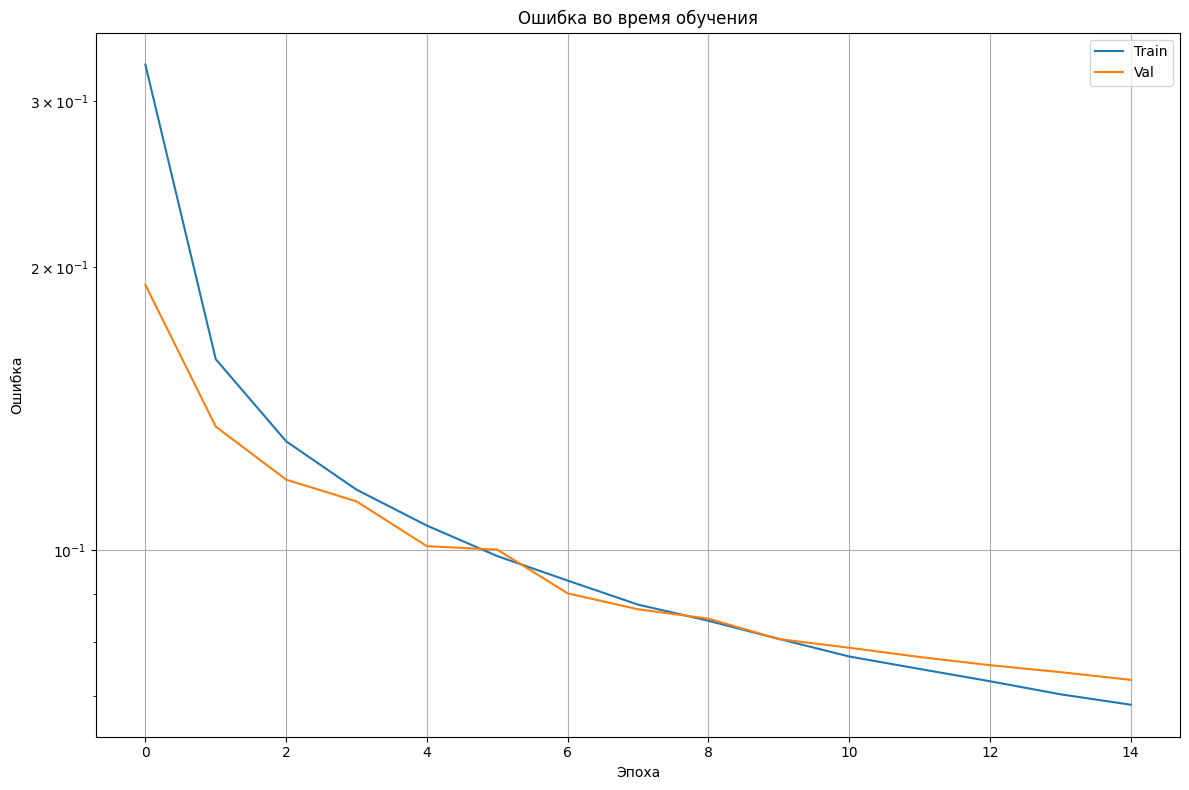

In [72]:
plot_loss(train_loss, valid_loss)

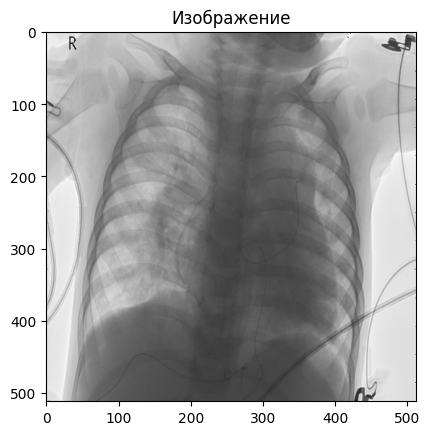

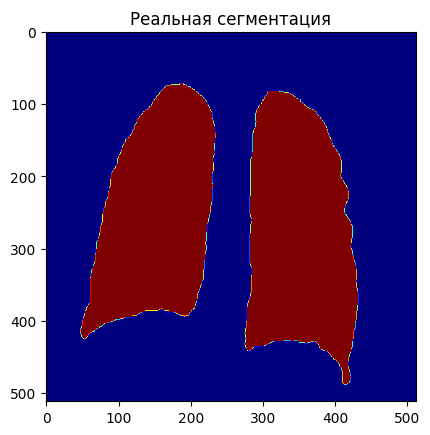

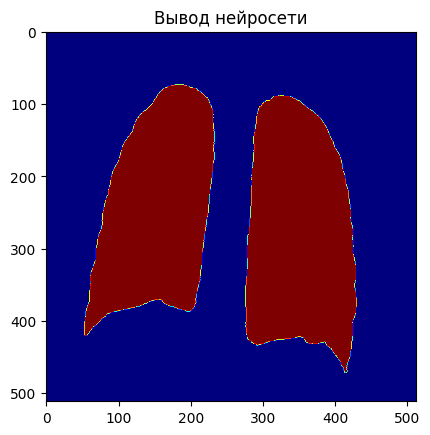

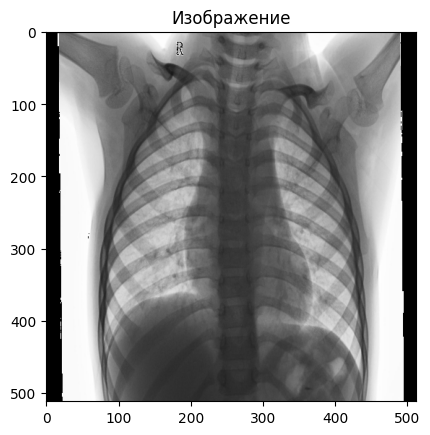

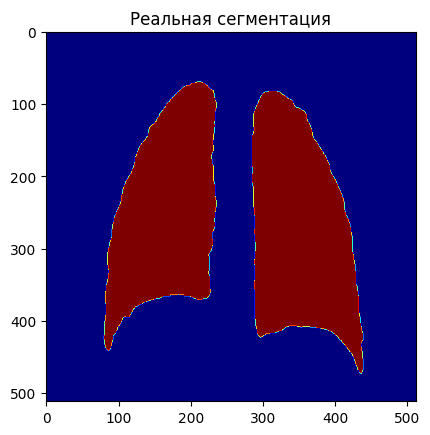

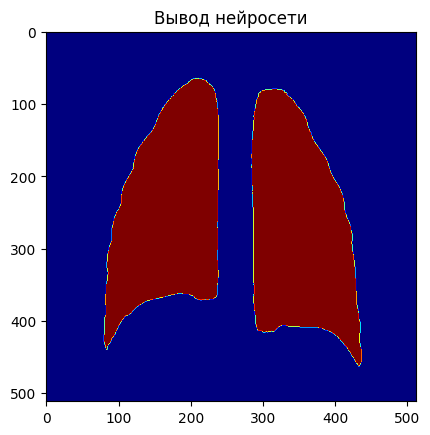

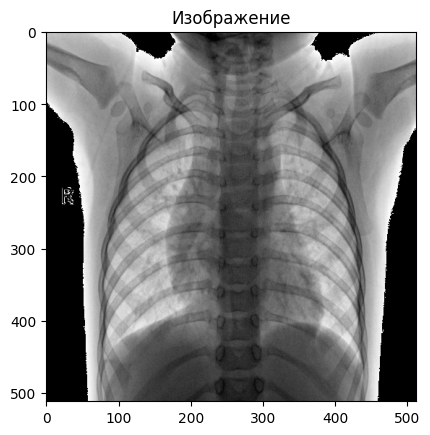

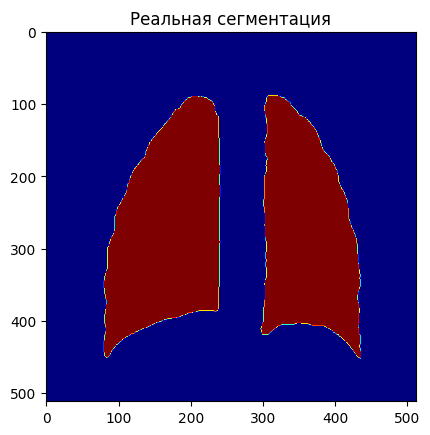

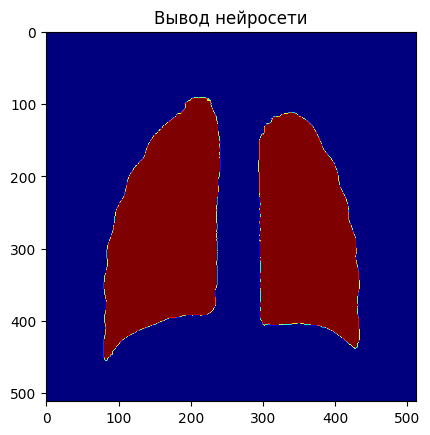

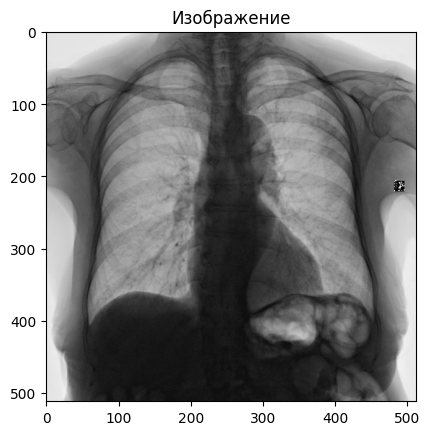

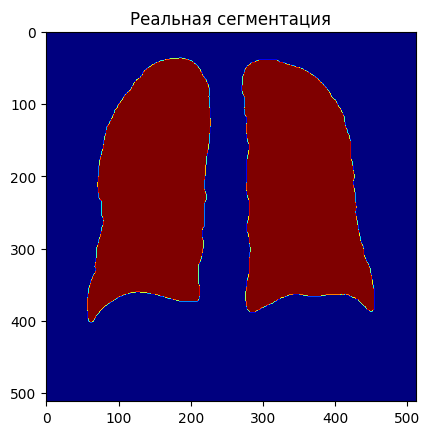

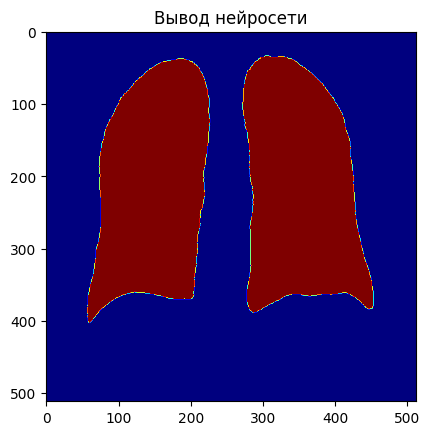

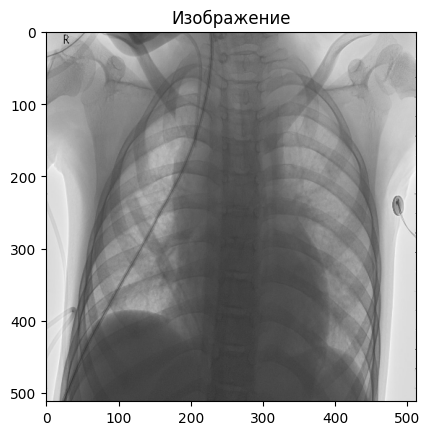

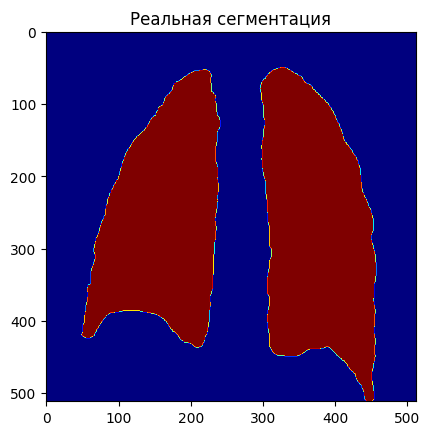

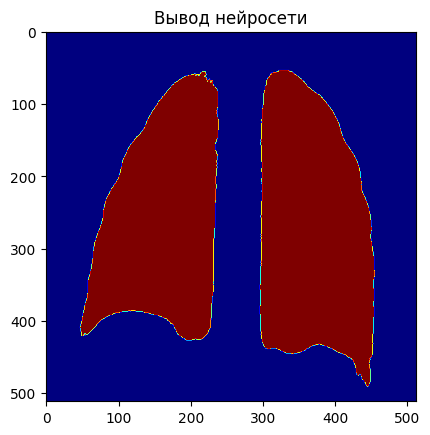

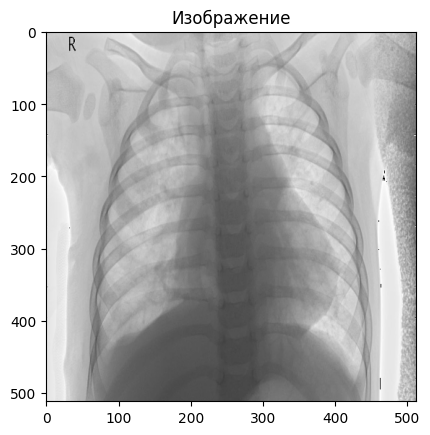

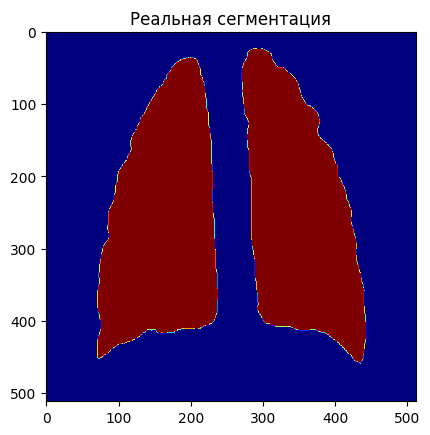

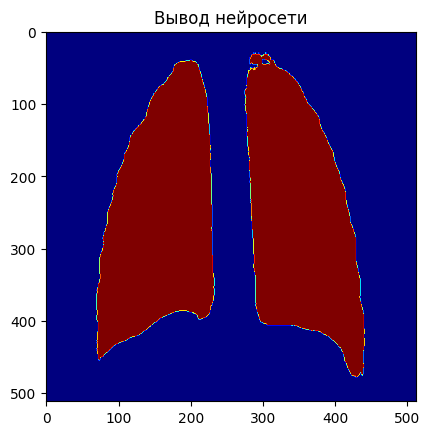

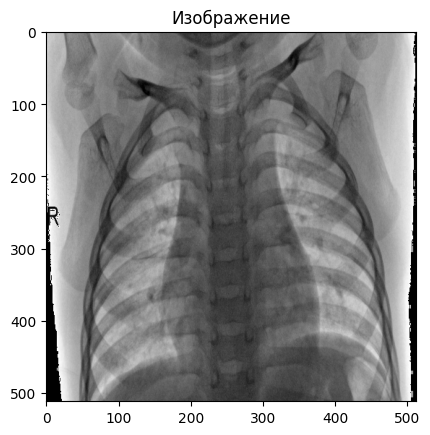

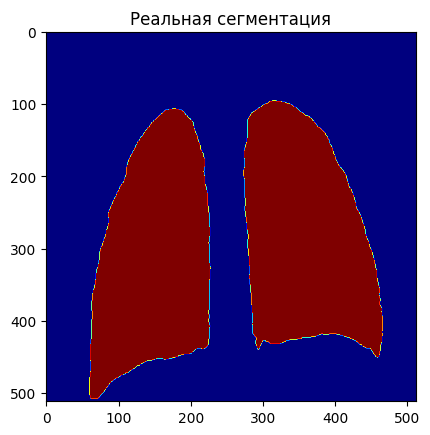

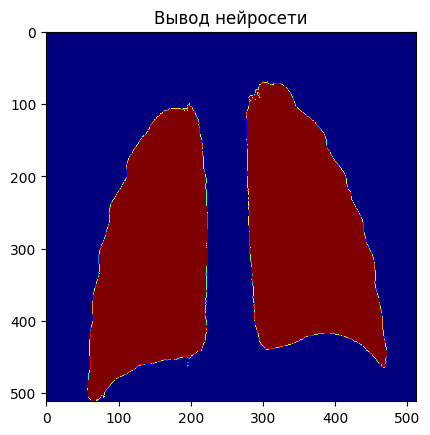

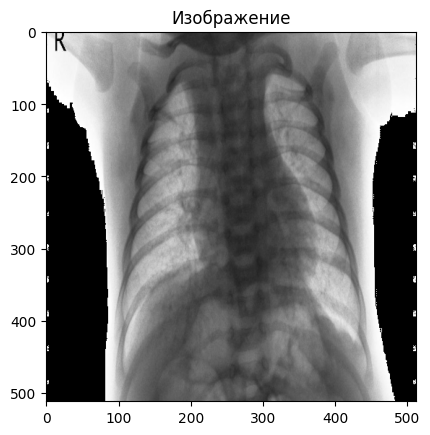

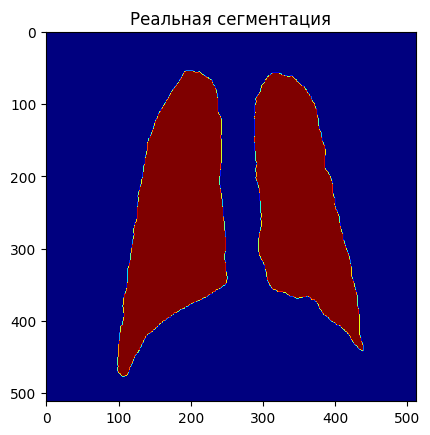

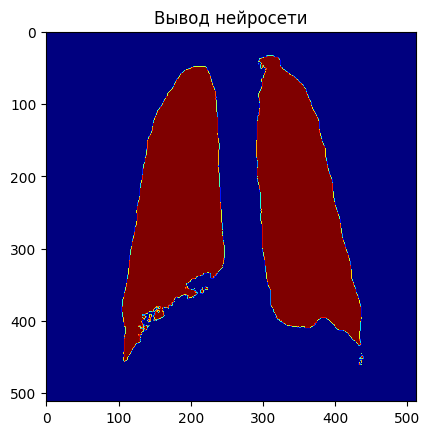

In [ ]:
X, y = None, None

for img, mask in ValLoader:
    X, y = img.to(device).float(), mask.to(device).float()
    break

y_ = Model.forward(X)

n = y.shape[0]
for index in range(n):
    debug_image_output(X[index], y[index], y_[index])

# 5. Посмотрим на метрики

In [ ]:
dice = []
IoU = []

dice_score = DiceScore(2)
meanIoU_score = MeanIoU(2)

for X, y in TestLoader:
    X, y = X.to(device).float(), y.to(device).int()
    y_ = Model.forward(X).squeeze()
    y_ = (sigmoid(y_) >= 0.5).int()

    dice_metric = dice_score(y_, y)
    meanIoU_metric = meanIoU_score(y_.cpu(), y.cpu())

    dice.append(dice_metric)
    IoU.append(meanIoU_metric)

print("Dice Metric on Test:", torch.Tensor(dice).mean())
print("Mean IoU Metric on Test:", torch.Tensor(IoU).mean())

Dice Metric on Test: tensor(0.9480)
Mean IoU Metric on Test: tensor(0.8537)
